 # Исследование сервиса аренды самокатов GoFast

Для анализа были предаставлены данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
    
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках.
Таблица пользователи — data_users
    
- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)
    
Таблица поездки — data_rides
    
- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки
    
Таблица подписки — data_subscriptions
    
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import sqrt
from math import factorial
from scipy.stats import binom, norm

#### Шаг 1. Загрузка данных

In [2]:
#Откроем файлы users_go.csv, rides_go.csv, subscriptions_go.csv

try:
    data_users = pd.read_csv('/datasets/users_go.csv')
    data_rides = pd.read_csv('/datasets/rides_go.csv')
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_users = pd.read_csv('users_go.csv')
    data_rides = pd.read_csv('rides_go.csv')
    data_subscriptions = pd.read_csv('subscriptions_go.csv')

##### Открытие таблицы data_users

In [3]:
#Выведем первые строки датафрейма data_users
display(data_users.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
#Рассмотрм основную информацию
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Пустых значений в данной таблице нет, типы данных соответствуют категориям значений, наименования приведены к змеиному регистру.

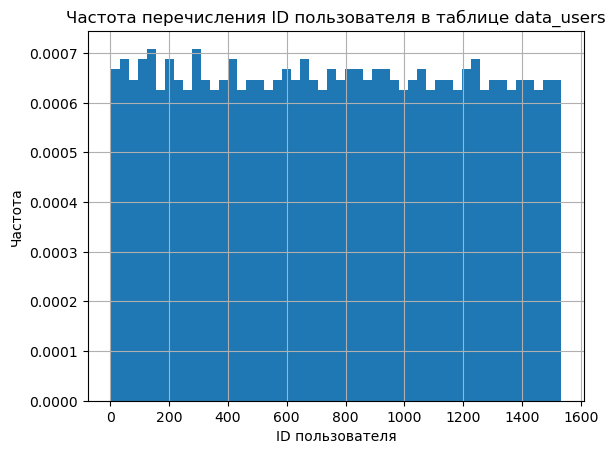

In [5]:
#Построим гистограмму для столбца user_id
plt.title(label='Частота перечисления ID пользователя в таблице data_users')
plt.xlabel('ID пользователя')
plt.ylabel('Частота')
plt.grid(True)
plt.hist(x=data_users['user_id'], bins=50, density=True);

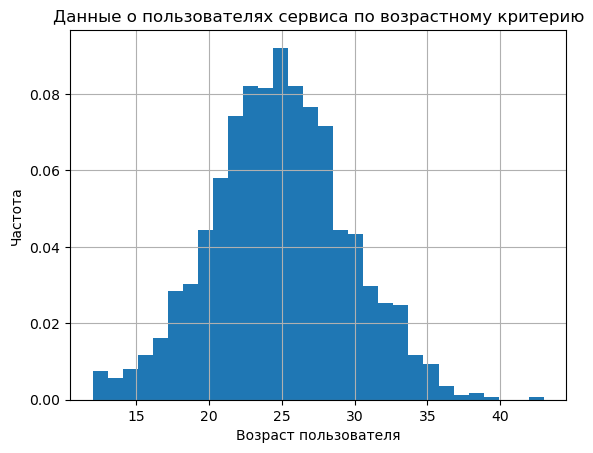

In [6]:
#Построим гистограмму для столбца age
plt.title(label='Данные о пользователях сервиса по возрастному критерию')
plt.xlabel('Возраст пользователя')
plt.ylabel('Частота')
plt.grid(True)
plt.hist(x=data_users['age'], bins=30, density=True);

Первый график свидетельствует о равномерном распределении id пользователей. Второй график показывает, что данными поездками пользуются пользователи разных возрастов, но чаще всего люди 25-26 лет.

##### Открытие таблицы data_rides

In [7]:
#Выведем первые строки датафрейма data_rides
display(data_rides.head())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
#Рассмотрм основную информацию
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Нет пустых значений, типы данных соответствуют категориям значений, наименования приведены к змеиному регистру, необходимо преобразовать столбец с датами к типу даты.

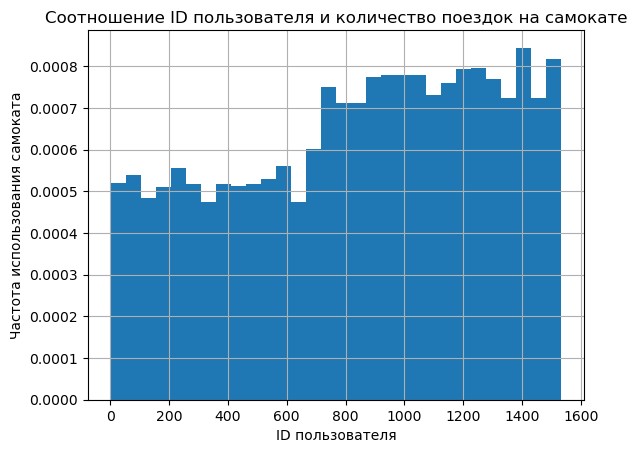

In [9]:
#Построим гистограмму для столбца user_id
plt.title(label='Соотношение ID пользователя и количество поездок на самокате')
plt.xlabel('ID пользователя')
plt.ylabel('Частота использования самоката')
plt.grid(True)
plt.hist(x=data_rides['user_id'], bins=30, density=True);

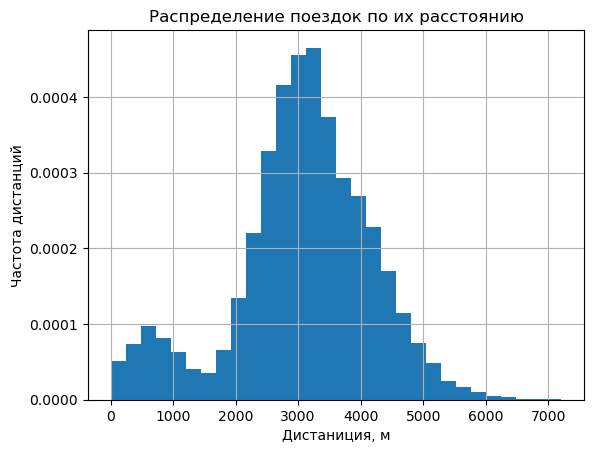

In [10]:
#Построим гистограмму для столбца distance
plt.title(label='Распределение поездок по их расстоянию')
plt.xlabel('Дистаниция, м')
plt.ylabel('Частота дистанций')
plt.grid(True)
plt.hist(x=data_rides['distance'], bins=30, density=True);

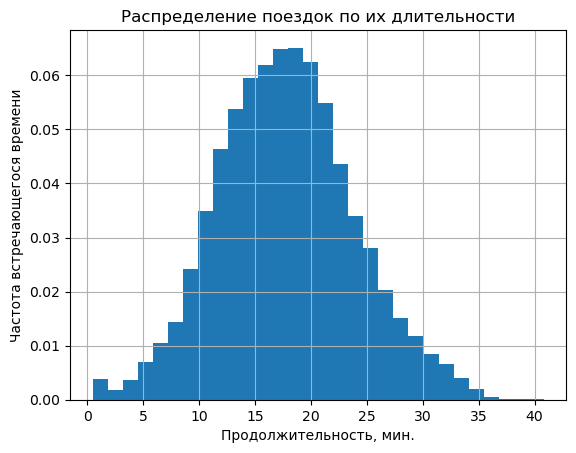

In [11]:
#Построим гистограмму для столбца duration
plt.title(label='Распределение поездок по их длительности')
plt.xlabel('Продолжительность, мин.')
plt.ylabel('Частота встречающегося времени')
plt.grid(True)
plt.hist(x=data_rides['duration'], bins=30, density=True);

На первой гистограмме показано распределение частоты поездок каждого пользователя. 
Вторая гистограмма показывает для каких дистанций чаще всего используют самокаты (2900-3600м).
Третья гистограмма отображает продолжительность поездок, чаще всего это 16-20 минут. 

##### Открытие таблицы data_subscriptions

In [12]:
#Выведем первые строки датафрейма data_subscriptions
display(data_subscriptions.head())

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [13]:
#Рассмотрм основную информацию
data_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Пустые значения в таблице обоснованы нулевой ценой, типы данных соответствуют категориям значений, наименования приведены к змеиному регистру, данные соответствуют заявленному описанию.

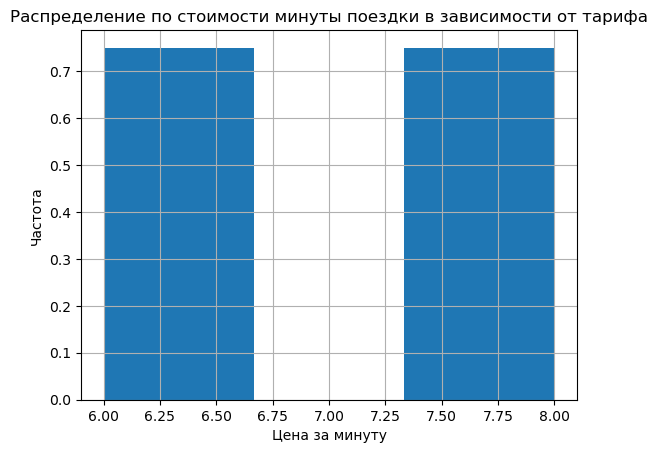

In [14]:
#Построим гистограмму для столбца minute_price
plt.title(label='Распределение по стоимости минуты поездки в зависимости от тарифа')
plt.xlabel('Цена за минуту')
plt.ylabel('Частота')
plt.grid(True)
plt.hist(x=data_subscriptions['minute_price'], bins=3, density=True);

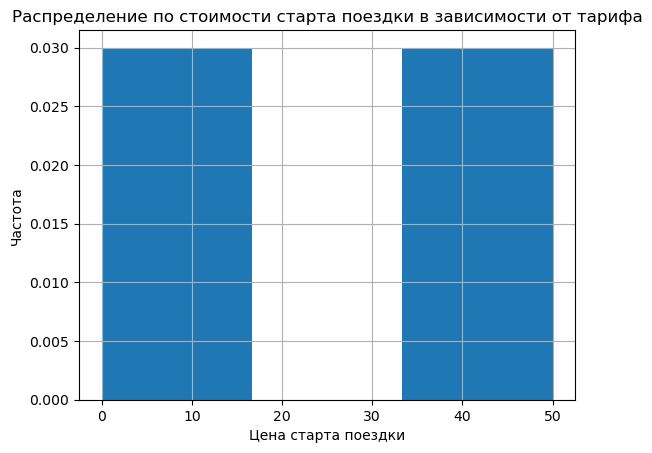

In [15]:
#Построим гистограмму для столбца start_ride_price
plt.title(label='Распределение по стоимости старта поездки в зависимости от тарифа')
plt.xlabel('Цена старта поездки')
plt.ylabel('Частота')
plt.grid(True)
plt.hist(x=data_subscriptions['start_ride_price'], bins=3, density=True);

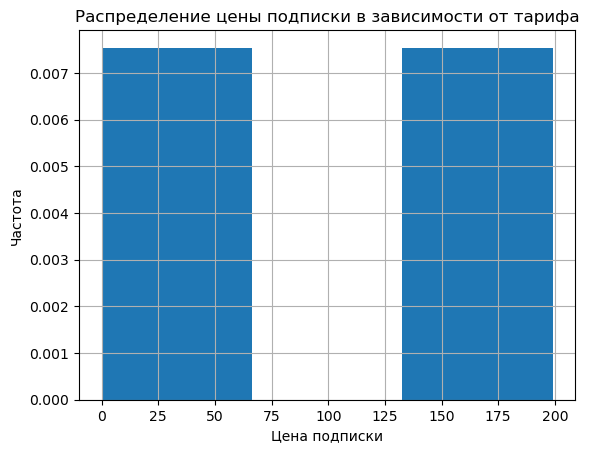

In [16]:
#Построим гистограмму для столбца subscription_fee
plt.title(label='Распределение цены подписки в зависимости от тарифа')
plt.xlabel('Цена подписки')
plt.ylabel('Частота')
plt.grid(True)
plt.hist(x=data_subscriptions['subscription_fee'], bins=3, density=True);

Все представленные гистограммы отражают значения двух тарифов: ultra и free, поэтому график приобретает значение с двумя горизонтальными линиями.

#### Шаг 2. Предобработка данных

##### Рассмотрение и преобразование таблицы data_users

In [17]:
#Рассмотрим общее количество пропусков по таблице data_users
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [18]:
#Проверим таблицу data_users на наличие дубликатов на начальном этапе
data_users.duplicated().sum()

31

In [19]:
#Выведем выявленные дубликаты в таблице data_users
data_users[data_users.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [20]:
#Исключим дубликаты из выборки
data_users = data_users.drop_duplicates()
data_users = data_users.reset_index(drop=True)

In [21]:
#Проверим таблицу на наличие дубликатов после проведенных действий
data_users.duplicated().sum()

0

In [22]:
#Рассмотрм разброс значений в таблице data_users
data_users['age'].value_counts()

25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

Категоризируем данные для более наглядной работы в последующем
- 0–20 — 'младше 21';
- 21–25 — '21-25';
- 26–30 — '26-30';
- 31 и старше — 'старше 30'.

In [23]:
#Категоризируем данные по возрасту пользователей
def categorize_age(row):
    try:
        if 0 <= row <= 20:
            return 'младше 21'
        elif 21 <= row <= 25:
            return '21-25'
        elif 26 <= row <= 30:
            return '26-30'
        elif row >= 31:
            return 'старше 30'
    except:
        pass

In [24]:
#Применим функцию к таблице и запишем категории для каждой строки
data_users['categorize_age'] = data_users['age'].apply(categorize_age)

In [25]:
data_users.head()

,user_id,name,age,city,subscription_type,categorize_age
0,1,Кира,22,Тюмень,ultra,21-25
1,2,Станислав,31,Омск,ultra,старше 30
2,3,Алексей,20,Москва,ultra,младше 21
3,4,Константин,26,Ростов-на-Дону,ultra,26-30
4,5,Адель,28,Омск,ultra,26-30


In [26]:
#Рассмотрим полученные возрастные категории 
data_users['categorize_age'].value_counts()

21-25        618
26-30        498
младше 21    243
старше 30    175
Name: categorize_age, dtype: int64

**Промежуточный вывод:** 
   
Если рассматривать частоту возрастов пользователей, как нормальное распределение (х - возраст, у - частота), то левый и правый края графика будут ближе всего к оси х, это возраста младше 21 и старше 30 лет соответственно. Возможными причинами могут быть для категории младше 21 - отсутствие необходимости в дальних передвижениях или отсутствие достаточной финансовой составляющей, для категории страше 30 - возможное наличие своего транспорта.
    
Чаще всего арендой самокатов пользуются молодые люди в возрасте от 21 до 30 лет.

##### Рассмотрение и преобразование таблицы data_rides

In [27]:
#Рассмотрим общее количество пропусков по таблице data_rides
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [28]:
#Проверим таблицу data_rides на наличие дубликатов на начальном этапе
data_rides.duplicated().sum()

0

In [29]:
#Приведем даты в таблице data_rides к формату даты
data_rides['date_datetime'] = pd.to_datetime(
    data_rides['date'], format='%Y.%m.%d'
)

In [30]:
#Проверим формат 
data_rides['date_datetime'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date_datetime, dtype: datetime64[ns]

Дата приведена к формату datetime64.

In [31]:
#Запишем в таблицу месяц, когда самокат находился в аренде у пользователя
data_rides['month'] = data_rides['date_datetime'].dt.month

Категоризируем данные по рассмтоянию, для наглядности работы в последующем:
- 0–2000 — 'до 2001м'; 
- 2001–3000 — '2001–3000м'; 
- 3001–4000 — '3001–4000м'; 
- 4001 и более — 'более 4000м'.

In [32]:
#Категоризируем данные по дистанциям
def categorize_distance(row):
    try:
        if 0 <= round(row) <= 2000:
            return 'до 2000м'
        elif 2001 <= round(row) <= 3000:
            return '2001–3000м'
        elif 3001 <= round(row) <= 4000:
            return '3001–4000м'
        elif round(row) >= 4001:
            return 'более 4001м'
    except:
        pass

In [33]:
#Применим функцию к таблице и запишем категории для каждой строки
data_rides['categorize_distance'] = data_rides['distance'].apply(categorize_distance)

Категоризируем данные по времени поездки, для наглядности работы в последующем:
- 0–10 — 'менее 11 мин.'; 
- 11–15 — '11–15 мин.'; 
- 16–20 — '16–20 мин.'; 
- 21–25 — '21–25 мин.';
- 25 и более — 'более 25 мин.'.

In [34]:
#Категоризируем данные по времени поездки
def categorize_duration(row):
    try:
        if 0 <= round(row) <= 10:
            return 'менее 11 мин.'
        elif 11 <= round(row) <= 15:
            return '11–15 мин.'
        elif 16 <= round(row) <= 20:
            return '16–20 мин.'
        elif 21 <= round(row) <= 25:
            return '21–25 мин.'
        elif round(row) >= 26:
            return 'более 25 мин.'
    except:
        pass

In [35]:
#Применим функцию к таблице и запишем категории для каждой строки
data_rides['categorize_duration'] = data_rides['duration'].apply(categorize_duration)

In [36]:
#Проверим результат 
data_rides.head()

,user_id,distance,duration,date,date_datetime,month,categorize_distance,categorize_duration
0,1,4409.919140,25.599769,2021-01-01,2021-01-01,1,более 4001м,более 25 мин.
1,1,2617.592153,15.816871,2021-01-18,2021-01-18,1,2001–3000м,16–20 мин.
2,1,754.159807,6.232113,2021-04-20,2021-04-20,4,до 2000м,менее 11 мин.
3,1,2694.783254,18.511000,2021-08-11,2021-08-11,8,2001–3000м,16–20 мин.
4,1,4028.687306,26.265803,2021-08-28,2021-08-28,8,более 4001м,более 25 мин.


**Промежуточный вывод:** 
 
Меньше всего пользуются спросом поездки предельно кароткие или предельно длинные менее 11 минут или более 25 минут сответственно. Поедки продолжительностью от 11 до 25 минут являются более востребованными. Чаще всего поездка длится 17-20 минут.
 
- менее 11 мин.    1904
- 11–15 мин.       4627
- 16–20 мин.       5778
- 21–25 мин.       3822
- более 25 мин.    1937

Для поездки на расстояние менее 2 км и более 4 км пользователи чаще прибегают к альтернативным методам передвижения. Самые часто встречающиестся по метрожу поезки это от 2 км до 4 км. Если рассматривать детальнее самокаты арендуют чаще всего для поездок на расстояние 3 - 3,5 км.
   
- до 2000м       2352
- 2001–3000м     5546
- 3001–4000м     6692
- более 4001м    3478

##### Рассмотрение таблицы data_subscriptions

In [37]:
#Рассмотрим общее количество пропусков по таблице data_subscriptions
data_subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [38]:
#Проверим таблицу data_subscriptions на наличие дубликатов на начальном этапе 
#так как имеется 2 тарифа, на данном этапе зафиксируем отсутствие дубликатов
data_subscriptions.duplicated().sum()

0

**Промежуточный вывод:** 
   
Данные этой таблицы не имеют пропусков, так как описывают всего 2 тарифа: ultra и free.
Нулевые значения в случае с таблицей data_subscriptions означают нулевую стоимость.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

In [39]:
#Посчитаем количество пользователей из разных городов
data_city = data_users['city'].value_counts()
data_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

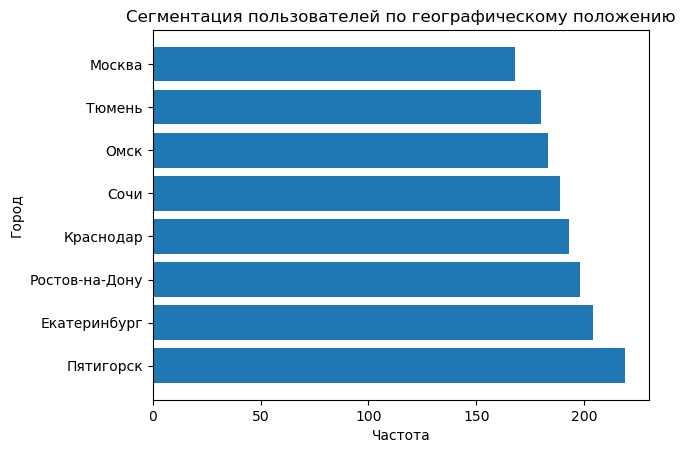

In [40]:
#Построим гистограмму частоты встречаемости городов
plt.title(label='Сегментация пользователей по географическому положению')
data_city = pd.DataFrame({'city':['Пятигорск', 'Екатеринбург', 
                                  'Ростов-на-Дону', 'Краснодар', 
                                  'Сочи', 'Омск', 'Тюмень', 'Москва'],
                          'frequency':[219, 204, 198, 193, 189, 183, 180, 168]})
plt.barh(y=data_city['city'], width=data_city['frequency'])
plt.ylabel('Город')
plt.xlabel('Частота');

Больше всего пользователей, пользующихся арендой самокатов находится в Пятигорске, меньше всего в Москве, это может быть обосновано отдаленностью пунктов отправления и назначения, поэтому в Москве может быть не выгодно арендовать самокат для такого расстояния.

##### Соотношение пользователей с подпиской и без подписки

In [41]:
#Выведем количество пользователей, использующих разные тарифы
data_users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

In [42]:
data_type = pd.DataFrame({'type':['Без подписки', 'С подпиской'],
                          'frequency':[835, 699]})

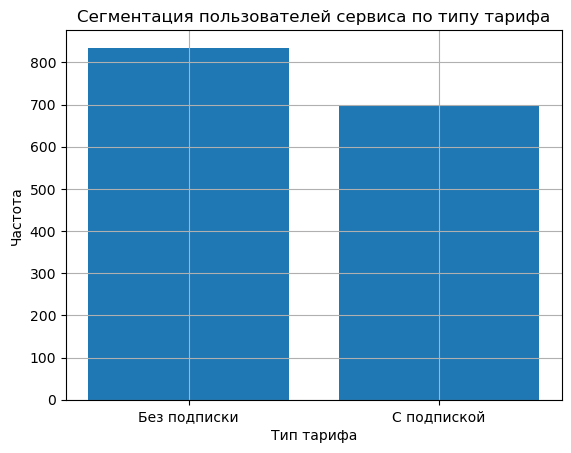

In [43]:
#Построим гистограмму для столбца subscription_type
plt.title(label='Сегментация пользователей сервиса по типу тарифа')
plt.bar(x=data_type['type'], height=data_type['frequency'])
plt.xlabel('Тип тарифа')
plt.ylabel('Частота')
plt.grid(True);

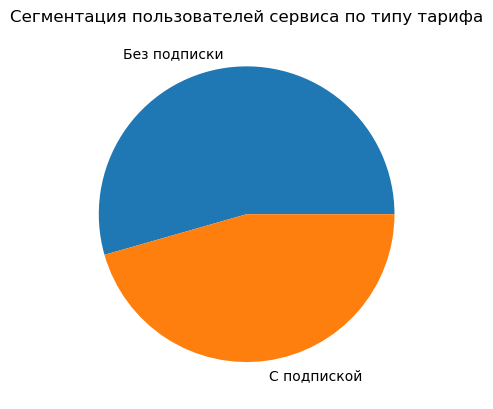

In [44]:
#Построим гистограмму для столбца subscription_type
plt.title(label='Сегментация пользователей сервиса по типу тарифа')
plt.pie(x=data_type['frequency'], labels=data_type['type']);

Согласно гистограмме и круговой диаграмме пользователей без подписки больше. Это может быть обусловлено отсутствием необходимости покупки подписки при разовой аренде самоката, или же невыгодным соотношением дистанций и ценой за эту дистанцию.

##### Возраст пользователей

In [45]:
#Выведем количество пользователей разных возрастов
data_users['age'].value_counts()

25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

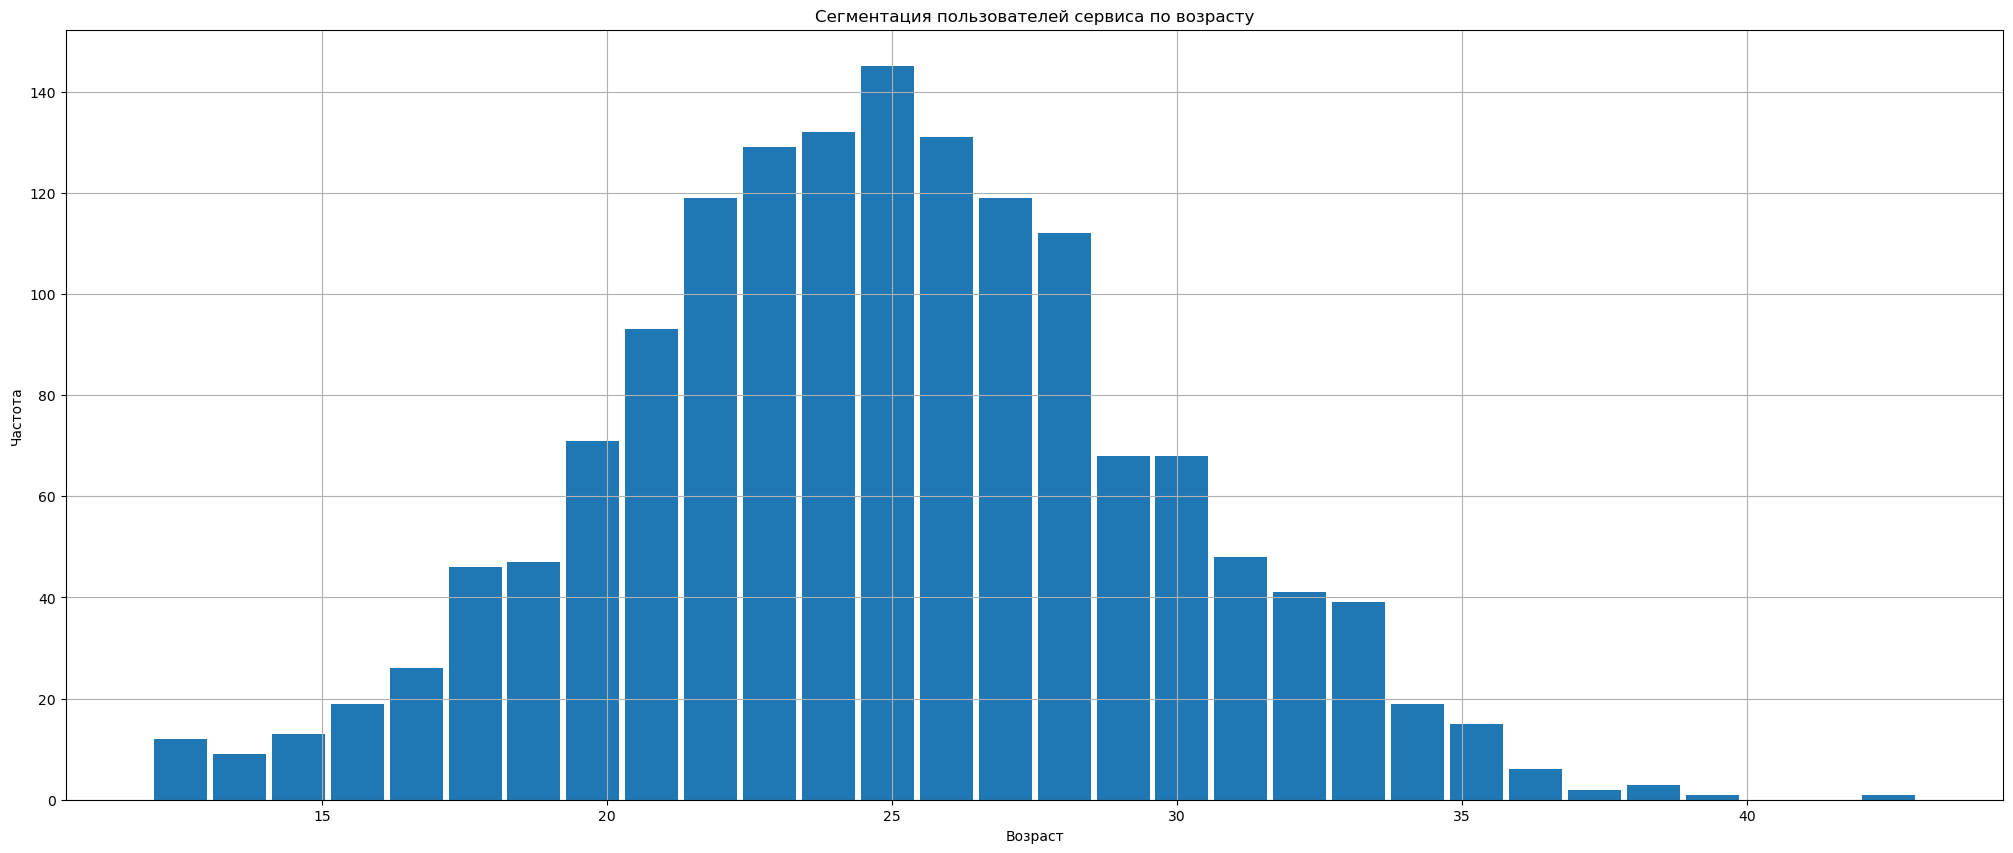

In [46]:
#Построим гистограмму
plt.title(label='Сегментация пользователей сервиса по возрасту')
data_users['age'].hist(bins=30, figsize=(25, 10), rwidth= .9);
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(True);

In [47]:
#Выведем количество пользователей разных возрастов категоризированных данных
data_users['categorize_age'].value_counts(ascending=False)

21-25        618
26-30        498
младше 21    243
старше 30    175
Name: categorize_age, dtype: int64

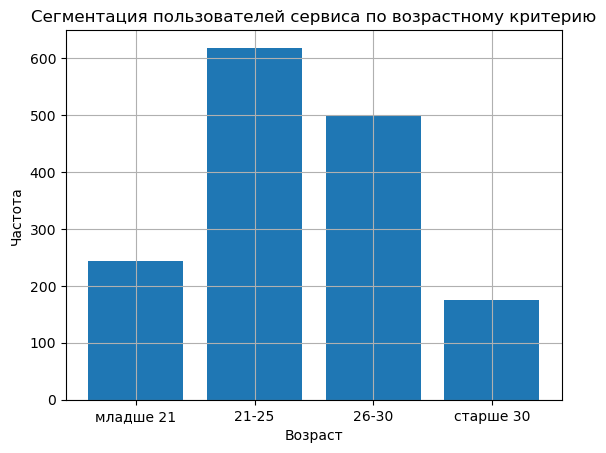

In [48]:
#Построим гистограмму
plt.title(label='Сегментация пользователей сервиса по возрастному критерию')
data_age = pd.DataFrame({'age':['младше 21', '21-25', '26-30', 'старше 30'],
                         'frequency':[243, 618, 498, 175]})
plt.bar(x=data_age['age'], height=data_age['frequency'])
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(True);

Чаще всего услугой аренды самокатов ползуются молодые люди в возрасте от 21 до 25 лет. Меньше всего пользователи от 30 лет. Возможной причиной может быть наличчие своего транспорта.

##### Расстояние, которое пользователь преодолел за одну поездку

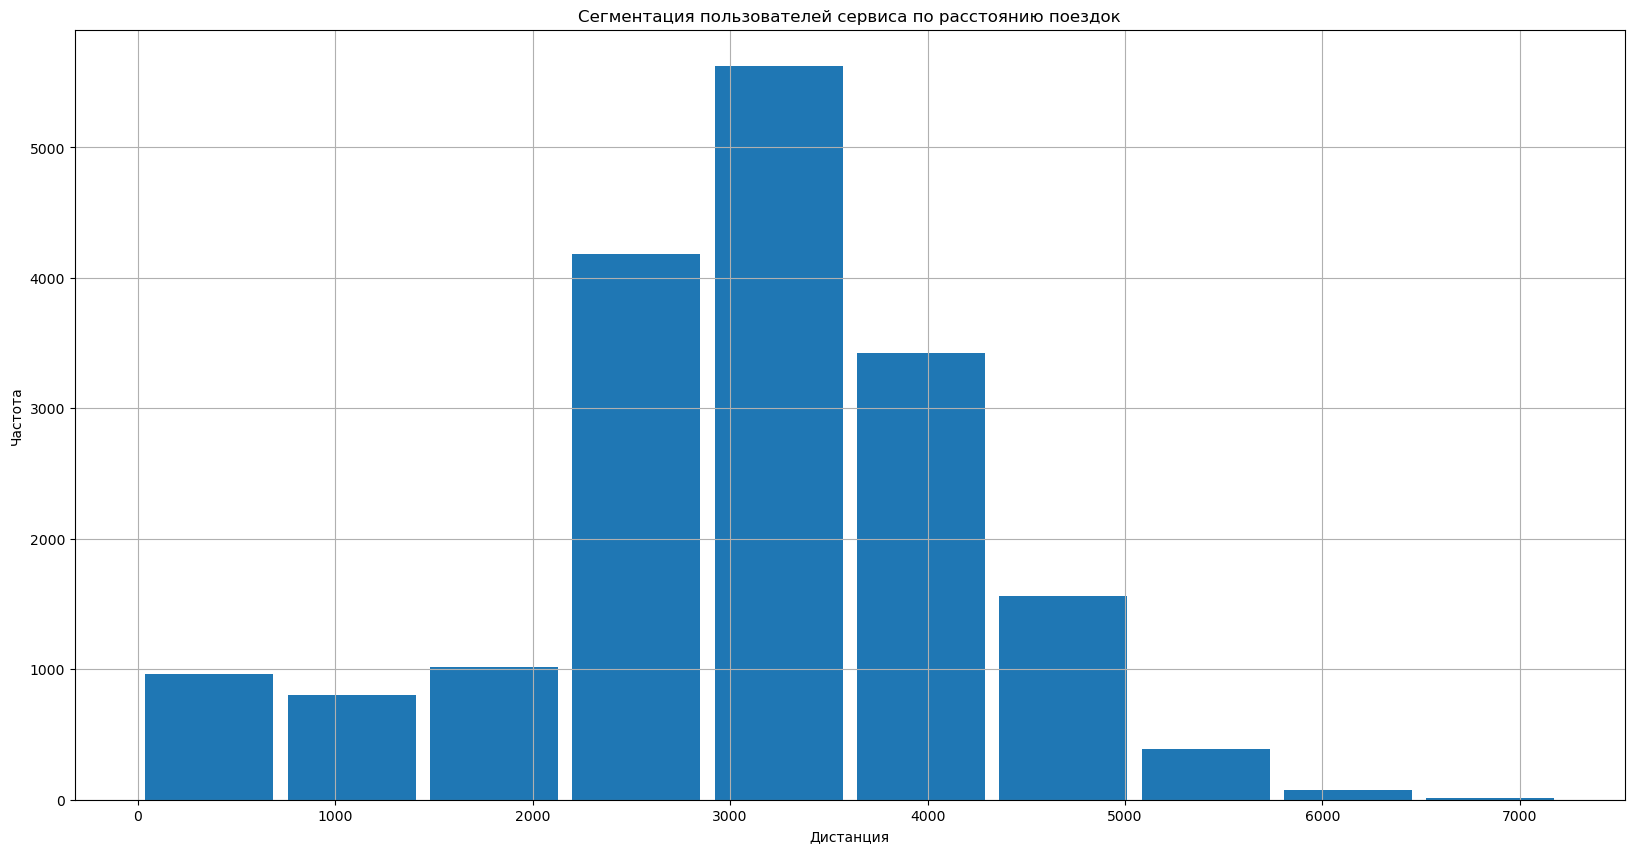

In [49]:
#Построим гистограмму по имеющимся данным
plt.title(label='Сегментация пользователей сервиса по расстоянию поездок')
data_rides['distance'].hist(figsize=(20, 10), rwidth= .9)
plt.xlabel('Дистанция')
plt.ylabel('Частота')
plt.grid(True);

In [50]:
#Выведем ранее сформированные категоризированные данные
data_rides['categorize_distance'].value_counts(ascending=False)

3001–4000м     6692
2001–3000м     5546
более 4001м    3478
до 2000м       2352
Name: categorize_distance, dtype: int64

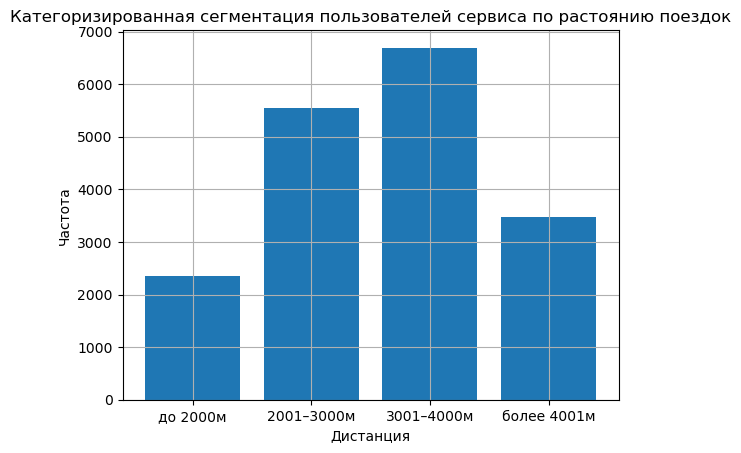

In [51]:
#Построим гистограмму
plt.title(label='Категоризированная сегментация пользователей сервиса по растоянию поездок')
data_distance = pd.DataFrame({'distance':['до 2000м', '2001–3000м', '3001–4000м', 'более 4001м'],
                         'frequency':[2352, 5546, 6692, 3478]})
plt.bar(x=data_distance['distance'], height=data_distance['frequency'])
plt.xlabel('Дистанция')
plt.ylabel('Частота')
plt.grid(True);

Чаще всего самокаты арендуют для передвижения на расстояние от 3 до 4 км.

##### Продолжительность поездок

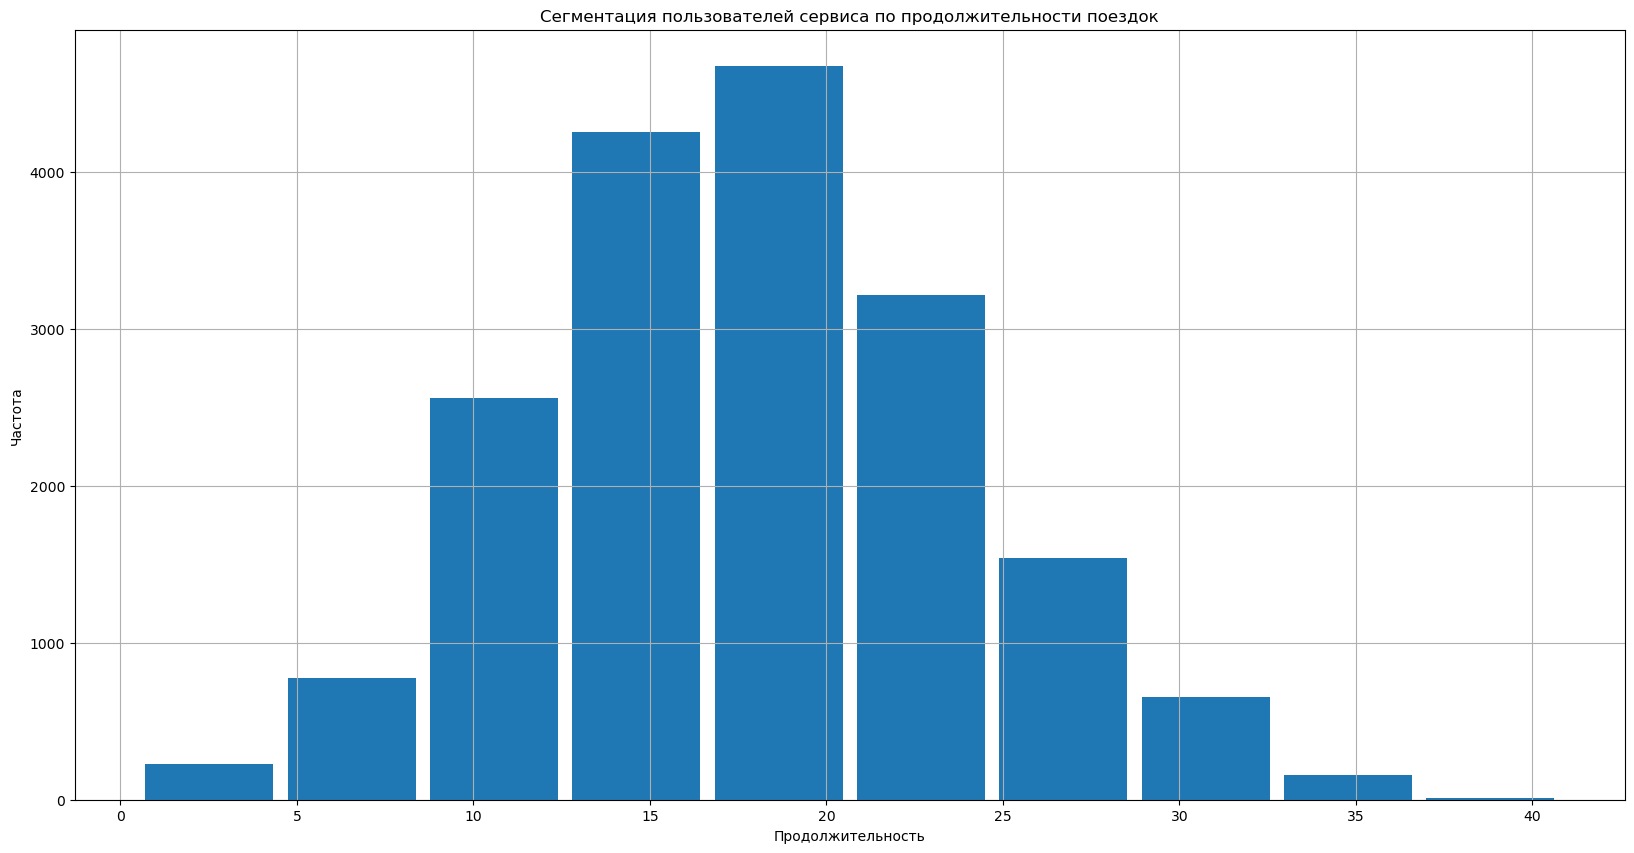

In [52]:
#Построим гистограмму по имеющимся данным
plt.title(label='Сегментация пользователей сервиса по продолжительности поездок')
data_rides['duration'].hist(figsize=(20, 10), rwidth= .9)
plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.grid(True);

In [53]:
#Выведем ранее сформированные категоризированные данные
data_rides['categorize_duration'].value_counts(ascending=False)

16–20 мин.       5778
11–15 мин.       4627
21–25 мин.       3822
более 25 мин.    1937
менее 11 мин.    1904
Name: categorize_duration, dtype: int64

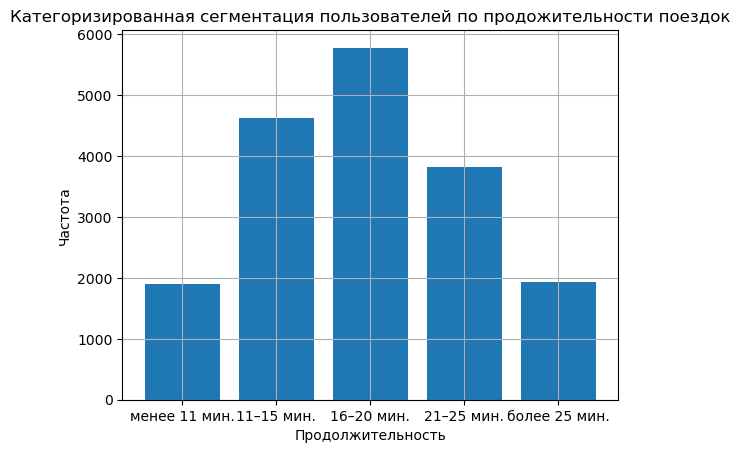

In [54]:
#Построим гистограмму
plt.title(label='Категоризированная сегментация пользователей по продожительности поездок')
data_duration = pd.DataFrame({'duration':['менее 11 мин.', '11–15 мин.', '16–20 мин.', '21–25 мин.', 'более 25 мин.'],
                         'frequency':[1904, 4627, 5778, 3822, 1937]})
plt.bar(x=data_duration['duration'], height=data_duration['frequency'])
plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.grid(True);

Чаще всего поездка длиться от 16 до 20 минут. Самыми же редкими стали поездки менее 11 минут и более 25. Что может обуславливаться либо слишком коротким расстоянием, либо же слишком длинным.

#### Шаг 4. Объединение данных

##### Создание общей таблицы

In [55]:
#Объединим данные таблиц data_users и data_rides
data = data_rides.merge(data_users, on='user_id', how='left')

In [56]:
#Объединим данные таблиц data и data_subscriptions
data = data.merge(data_subscriptions, on='subscription_type', how='left')

In [57]:
#Проверим результат
data.head()

,user_id,distance,duration,date,date_datetime,month,categorize_distance,categorize_duration,name,age,city,subscription_type,categorize_age,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,2021-01-01,1,более 4001м,более 25 мин.,Кира,22,Тюмень,ultra,21-25,6,0,199
1,1,2617.592153,15.816871,2021-01-18,2021-01-18,1,2001–3000м,16–20 мин.,Кира,22,Тюмень,ultra,21-25,6,0,199
2,1,754.159807,6.232113,2021-04-20,2021-04-20,4,до 2000м,менее 11 мин.,Кира,22,Тюмень,ultra,21-25,6,0,199
3,1,2694.783254,18.511000,2021-08-11,2021-08-11,8,2001–3000м,16–20 мин.,Кира,22,Тюмень,ultra,21-25,6,0,199
4,1,4028.687306,26.265803,2021-08-28,2021-08-28,8,более 4001м,более 25 мин.,Кира,22,Тюмень,ultra,21-25,6,0,199


In [58]:
#Проверим размерность получившейся таблицы
data.shape

(18068, 16)

##### Создание таблицы с данными пользователей с подпиской

In [59]:
#Создадим новый датафрейм на основе имеющегося
data_ultra = data[data['subscription_type'] == 'ultra']

In [60]:
#Проверим размерность получившейся таблицы
data_ultra.shape

(6500, 16)

##### Создание таблицы с данными пользователей без подписки

In [61]:
#Создадим новый датафрейм на основе имеющегося
data_free = data[data['subscription_type'] == 'free']

In [62]:
#Проверим размерность получившейся таблицы
data_free.shape

(11568, 16)

In [63]:
#Проверим корректность данных (18068)
6500 + 11568

18068

##### Создание графиков с данными двух таблиц по графе distance

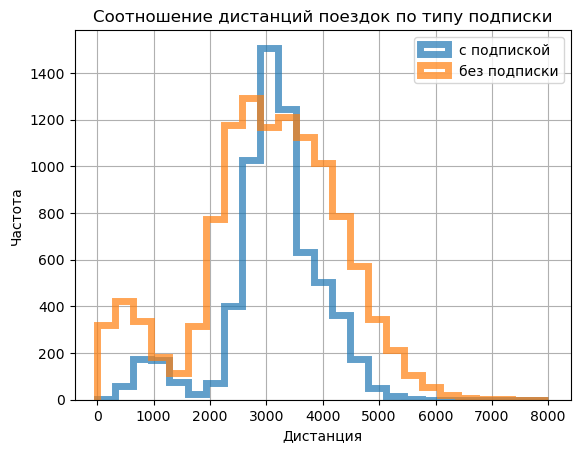

In [64]:
#Построим график, сравнивающий дистанции указанные в каждой из 2х таблиц (data_ultra и data_free) 

ax_1 = data_ultra.plot(
    kind='hist',
    y='distance',
    histtype='step',
    range=(0, 8000),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='ultra',
)
data_free.plot(
    kind='hist',
    y='distance',
    histtype='step',
    range=(0, 8000),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='free',
    ax=ax_1,
    grid=True,
    legend=True,
)
plt.title(label='Соотношение дистанций поездок по типу подписки')
plt.xlabel('Дистанция')
plt.ylabel('Частота')
plt.grid(True)
plt.legend(['с подпиской', 'без подписки']);

На графике видно, что пользователи с подпиской чаще совершают более длинные поездки.

##### Создание графиков с данными двух таблиц по графе duration

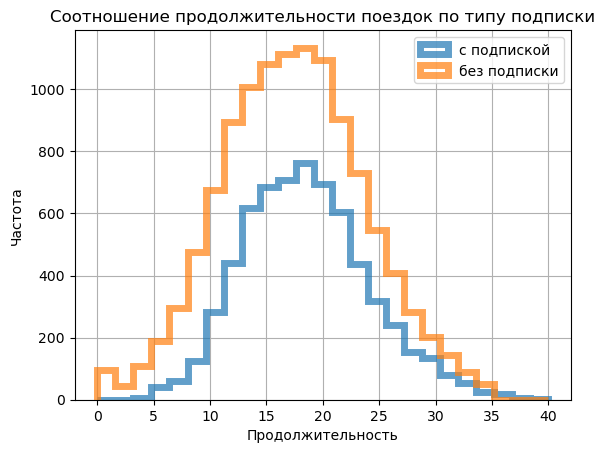

In [65]:
#Построим график, сравнивающий продолжительность поездок, 
#указанных в каждой из 2х таблиц (data_ultra и data_free) 
ax_2 = data_ultra.plot(
    kind='hist',
    y='duration',
    histtype='step',
    range=(0, 40),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='ultra',
)
data_free.plot(
    kind='hist',
    y='duration',
    histtype='step',
    range=(0, 40),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='free',
    ax=ax_2,
    grid=True,
    legend=True,
)
plt.title(label='Соотношение продолжительности поездок по типу подписки')
plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.grid(True)
plt.legend(['с подпиской', 'без подписки']);

По графику можно сказать, что пользователи без подписки используют самокат дольше, чем позователи с подпиской. Так как растояние поездок у пользователей без подписки меньше, возможной причиной такого соответствия может быть использование разных скоростных режимов, что в свою очередь может быть следствием малого опыта вождения самоката.

#### Шаг 5. Подсчёт выручки

##### Создание общей таблицы с выручкой

In [66]:
#Создаем сводную таблицу с данными о поездке
data_new = data.pivot_table(index=['user_id', 'month'], 
                            values=['distance', 'duration'], 
                            aggfunc='sum')

In [67]:
#Создаем сводную таблицу с данными о подписке
data_pivot = data.pivot_table(index=['user_id', 'month'], 
                              values=['subscription_type'], 
                              aggfunc='count')

In [68]:
#Соединяем полученные данные в общую таблицу с даннми о пользователях по месяцам
data_new = data_new.merge(data_pivot, on=['user_id', 'month'], how='left')
data_new = data_new.rename(columns={'subscription_type': 'count'})

In [69]:
#Приводим значение продолжительности поездки к нужному формату
data_new['duration'] = np.ceil(data_new['duration'])

In [70]:
#Перезапишем индексы
data_new = data_new.reset_index()

In [71]:
#Проверим получившуюся таблицу
data_new.head()

,user_id,month,distance,duration,count
0,1,1,7027.511294,42.0,2
1,1,4,754.159807,7.0,1
2,1,8,6723.470560,45.0,2
3,1,10,5809.911100,32.0,2
4,1,11,7003.499363,54.0,3


In [72]:
#Рассмотрим размерность таблицы
data_new.shape

(11331, 5)

In [73]:
#Создадим аналогичную таблицу с даннми по подписке
data_new_copy = data.pivot_table(index=['user_id', 'month'], 
                                 values=['distance', 'duration'], 
                                 aggfunc='sum')

In [74]:
#Добавим столбец с количеством поездок за месяц
data_pivot_copy = data.pivot_table(index=['user_id','month'], values=['city'], aggfunc='count')

In [75]:
#Сформируем данные о подписке
data_pivot_type = data.pivot_table(index=['subscription_type', 'user_id'], 
                                   values=['minute_price', 'start_ride_price', 'subscription_fee'])
data_pivot_type = data_pivot_type.reset_index()

In [76]:
#Соединим таблицы
data_new_copy = data_new_copy.merge(data_pivot_copy, on=['user_id', 'month'], how='left')
data_new_copy = data_new_copy.rename(columns={'city': 'count'})
data_new_copy['duration'] = np.ceil(data_new_copy['duration'])

In [77]:
#Добавим данные о подписке
data_new_copy = data_new_copy.merge(data_pivot_type, on=['user_id'], how='left')

In [78]:
#Проверим получившуюся таблицу
data_new_copy.head()

,user_id,distance,duration,count,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,7027.511294,42.0,2,ultra,6,0,199
1,1,754.159807,7.0,1,ultra,6,0,199
2,1,6723.470560,45.0,2,ultra,6,0,199
3,1,5809.911100,32.0,2,ultra,6,0,199
4,1,7003.499363,54.0,3,ultra,6,0,199


In [79]:
#Рассмотрим размерность таблицы
data_new_copy.shape

(11331, 8)

Размерность сохранена.

In [80]:
#Вычислим выручку
data_new_copy['revenue'] = (data_new_copy['start_ride_price'] 
                            * data_new_copy['count']) + (data_new_copy['minute_price'] 
                                                         * data_new_copy['duration']) + data_new_copy['subscription_fee']

In [81]:
#Присвоим значения выручки таблице data_new
data_new['revenue'] = data_new_copy['revenue']

##### Создание таблицы с выручкой для пользователй с подпиской

In [82]:
#Создание таблицы с данными пользователей с подпиской 
data_revenue_ultra = data_new_copy[data_new_copy['subscription_type'] == 'ultra']

In [83]:
#Проверим получившуюся таблицу
data_revenue_ultra.head()

,user_id,distance,duration,count,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,7027.511294,42.0,2,ultra,6,0,199,451.0
1,1,754.159807,7.0,1,ultra,6,0,199,241.0
2,1,6723.470560,45.0,2,ultra,6,0,199,469.0
3,1,5809.911100,32.0,2,ultra,6,0,199,391.0
4,1,7003.499363,54.0,3,ultra,6,0,199,523.0


In [84]:
#Рассмотрим размерность таблицы
data_revenue_ultra.shape

(4533, 9)

##### Создание таблицы с выручкой для пользователй без подписки

In [85]:
#Создание таблицы с данными пользователей без подписки 
data_revenue_free = data_new_copy[data_new_copy['subscription_type'] == 'free']

In [86]:
#Проверим получившуюся таблицу
data_revenue_free.head()

,user_id,distance,duration,count,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
4533,700,2515.690719,15.0,1,free,8,50,0,170.0
4534,700,13446.659764,86.0,5,free,8,50,0,938.0
4535,700,3798.334905,19.0,1,free,8,50,0,202.0
4536,700,2984.551206,16.0,1,free,8,50,0,178.0
4537,700,5927.650988,29.0,2,free,8,50,0,332.0


In [87]:
#Рассмотрим размерность таблицы
data_revenue_free.shape

(6798, 9)

In [88]:
#Проверим корректность данных (18068)
4533 + 6798

11331

Размерность сохранена

In [89]:
#Выручка, которую принес пользователь за год 
data_revenue = data_new.pivot_table(index=['user_id'], values=['revenue'], aggfunc='sum')

In [90]:
data_revenue.head()

,revenue
user_id,
1,2442.0
2,2593.0
3,2809.0
4,2940.0
5,2660.0


#### Шаг 6. Проверка гипотез

##### Проверка гипотезы
Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

- H0 - средняя продолжительность 2-х выборок равна 
- H1 - средняя продолжительность поездки пользователей с подпиской больше, чем средняя продолжительность поездки пользователей без подписки

In [91]:
#Задаем уровень стат. значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше"
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Полученное значение p-value (~ 1.2804098316645618e-34) меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что средняя продолжительность поездки пользователей с подпиской больше.

##### Проверка гипотезы
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

- H0 - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 
- H1 - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку меньше 3130

In [92]:
# значение с которым сравниваем
value = 3130

# уровень статистической значимости
alpha = 0.05 

results = st.ttest_1samp(
    data_ultra['distance'], 
    value,
    alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.08046311521502146
Не отвергаем нулевую гипотезу


In [93]:
# Проверим среднюю для данной выборки
data_ultra['distance'].mean()

3115.4453880370247

По данным анализа среднее расстояние может быть как меньше, так и равно 3130м.

##### Проверка гипотезы
Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

- H0 - помесячная выручка от пользователей с подпиской равна помесячной выручке от пользователей без подписки
- H1 - помесячная выручка от пользователей с подпиской больше помесячной выручки от пользователей без подписки

In [94]:
# задаем уровень стат. значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше"
results = st.ttest_ind(data_revenue_ultra['revenue'], 
                       data_revenue_free['revenue'], 
                       alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


Полученное значение p-value (~ 2.8130926188487286e-35) меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что помесячная выручка от пользователей с подпиской больше помесячной выручки от пользователей без подписки.

##### Проверка гипотезы
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Гипотеза о равенстве средних для зависимых (парных) выборок

Необходимы будут имеющиеся данные до и после обновления сервера, которые станут первой и второй выборкой соответственно.

- H0 - количество обращений в поддержку не изменилось
- H1 - количество обращений в поддержку изменилось

Определить уровень значимости

alpha = 0.05

Проведите тест и посчитать p-значение

results = st.ttest_rel(before, after)

Если pvalue будет меньше установленного уровня значимости, мы отвергнем нулевую гипотезу о равенстве количества обращений до и после обновления. Если же нет, то нулевая гипотеза не может быть отвергнута, что значит возможное изменение количества обращений после обновления.

#### Шаг 7. Распределения

#####  Задача

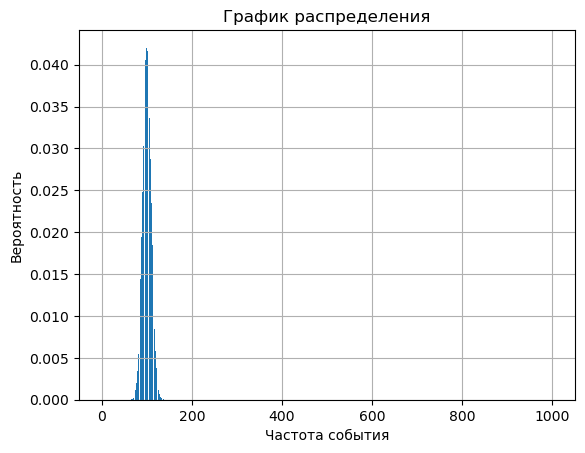

In [95]:
#Общее количество попыток нам не известно, если необходимо, 
#чтобы вероятность не выполнить план была примерно 5 %, укажеем 100 как мат.ожидание
mu = 100
p = 0.1

# тогда общее число попыток будет
n = int(mu / p)

distr_bar = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr_bar.append(prob)
    
# построим график  
plt.bar(range(0, n + 1), distr_bar)
plt.title(label='График распределения')
plt.xlabel('Частота события')
plt.ylabel('Вероятность')
plt.grid(True);

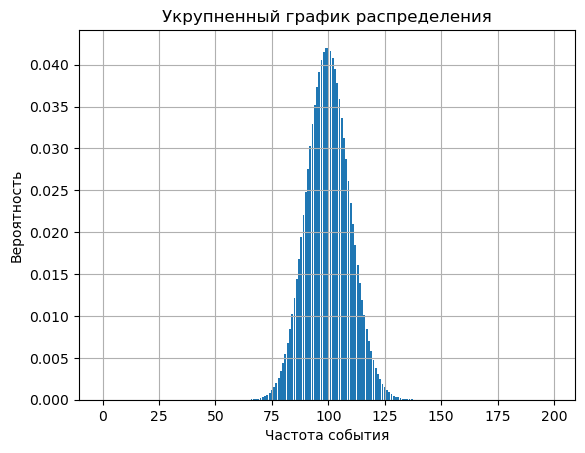

In [96]:
# построим график для диапазона (0, 200)
distr_bar = []

for k in range(0, 200):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr_bar.append(prob)
    

plt.bar(range(0, 200), distr_bar)
plt.title(label='Укрупненный график распределения')
plt.xlabel('Частота события')
plt.ylabel('Вероятность')
plt.grid(True);

In [97]:
#Проверим вероятность не выполнить план при данных параметрах
# дисперсия нормального распределения
sigma = sqrt(n * p * (1 - p))

# задаем нормальное распределение
distr = st.norm(mu, sigma) 

# находим вероятность
result = 1-(distr.cdf(100))
print(result)

0.5


Минимальным количеством промокодов, которое нужно разослать равно 1000. С вероятностью в 10% после проведения акции компания получит 100 новых пользователей, что будет являться мат. ожиданием, вероятность не выполнить план с данном случае равна 5%.

#####  Задача

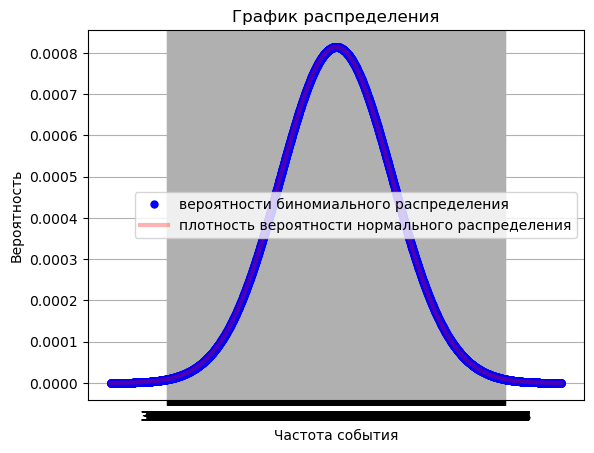

In [98]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4
    
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5,
label='вероятности биномиального распределения')

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 1000000 чисел от left до right
x = linspace(left, right, 1000000)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.title(label='График распределения')
plt.xlabel('Частота события')
plt.ylabel('Вероятность')
plt.grid(True)
plt.show()

В связи с большим количеством экспериментов, апроксимация биномиального распределения нормальным в данном случае подходит.

In [99]:
# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399.5 тысяч
result = 1-(distr.cdf(399500))
print(result)

0.8462829170363023


С вероятность 85% после рассылки 1 млн. уведомлений, уведомление откроют не более 399,5 тыс. пользователей.

####  Общий вывод

В результате проведенного анализа, были выполнеы следующие этапы:
- предобработка данных (были выявлены дубликаты, удалены и заполнены пустые значения)
- на основе обработанных данных были добавлены необходимые для дальнейшего анализа графы
- был проведен анализ как данных по отдельности, так и в совокупности

На основе полученных данных были проверены гипотезы. Для этого выдвигалась основаня и альтернативная гипотезы, выбирались уровни значимости, а также вид проводимого теста.

Были сформулированы следующие выводы:
- средняя продолжительность поездки пользователей с подпиской больше, чем пользователей без подписки
(p-value: 1.2804098316645618e-34)

- среднее расстояние для пользователей с подпиской может быть как меньше, так и равно 3130
(p-value: 0.08046311521502146)

- помесячная выручка от пользователей с подпиской больше помесячной выручки от пользователей без подписки
(p-value: 2.8130926188487286e-35)
